# Load Data

In [1]:
library(tidyverse)
library(ROSE)
library(corrplot)
library(caret)
library(randomForest)
set.seed(101)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loaded ROSE 0.0-3


corrplot 0.84 loaded

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [2]:
#load
data <- read.csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
#see structure
str(data)
#check for nulls
paste0("null data0: ", is.null(data))
#check how many strokes
paste0("Amount of Strokes: ", sum(data$stroke))

'data.frame':	5110 obs. of  12 variables:
 $ id               : int  9046 51676 31112 60182 1665 56669 53882 10434 27419 60491 ...
 $ gender           : Factor w/ 3 levels "Female","Male",..: 2 1 2 1 1 2 2 1 1 1 ...
 $ age              : num  67 61 80 49 79 81 74 69 59 78 ...
 $ hypertension     : int  0 0 0 0 1 0 1 0 0 0 ...
 $ heart_disease    : int  1 0 1 0 0 0 1 0 0 0 ...
 $ ever_married     : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 1 2 2 ...
 $ work_type        : Factor w/ 5 levels "children","Govt_job",..: 4 5 4 4 5 4 4 4 4 4 ...
 $ Residence_type   : Factor w/ 2 levels "Rural","Urban": 2 1 1 2 1 2 1 2 1 2 ...
 $ avg_glucose_level: num  229 202 106 171 174 ...
 $ bmi              : Factor w/ 419 levels "10.3","11.3",..: 240 419 199 218 114 164 148 102 419 116 ...
 $ smoking_status   : Factor w/ 4 levels "formerly smoked",..: 1 2 2 3 2 1 2 2 4 4 ...
 $ stroke           : int  1 1 1 1 1 1 1 1 1 1 ...


[1] "null data0: FALSE"

[1] "Amount of Strokes: 249"

In [3]:
prop.table(table(data$stroke))


         0          1 
0.95127202 0.04872798 

**Data is a lot unbalanced. Results will not be good if this is not taken it into account (that was confirmed during some tests).  <br>
Data will be balanced after train/test split.**

# Clean data

In [4]:
table(factor(data$gender))

cat("\nTable of Strokes (1)")
table(data$gender, data$stroke)

cat("\nGender to numeric")

data$gender <- as.character(data$gender)  
for (i in 1:length(data$gender)) {
    if (data$gender[i] == "Male") {
        data$gender[i] <- 1
    } 
    else if (data$gender[i] == "Female") {
        data$gender[i] <- 0
    } 
    else {    #replace other with NA...or something in between
        data$gender[i] <- 0.5
    }
}
data$gender <- as.numeric(data$gender)
print(head(data))


Female   Male  Other 
  2994   2115      1 


Table of Strokes (1)

        
            0    1
  Female 2853  141
  Male   2007  108
  Other     1    0


Gender to numeric     id gender age hypertension heart_disease ever_married     work_type
1  9046      1  67            0             1          Yes       Private
2 51676      0  61            0             0          Yes Self-employed
3 31112      1  80            0             1          Yes       Private
4 60182      0  49            0             0          Yes       Private
5  1665      0  79            1             0          Yes Self-employed
6 56669      1  81            0             0          Yes       Private
  Residence_type avg_glucose_level  bmi  smoking_status stroke
1          Urban            228.69 36.6 formerly smoked      1
2          Rural            202.21  N/A    never smoked      1
3          Rural            105.92 32.5    never smoked      1
4          Urban            171.23 34.4          smokes      1
5          Rural            174.12   24    never smoked      1
6          Urban            186.21   29 formerly smoked      1


In [5]:
table(factor(data$ever_married))
cat("\nTable of Strokes")
table(data$ever_married, data$stroke)
cat("Obviously, ever been married is much worse to have a Stroke!....\n")
cat("....probably just because it corresponds to someone older :) \n" )

cat("\nEver_married to binary")
data$ever_married <- as.numeric(data$ever_married) - 1 #to become binary


  No  Yes 
1757 3353 


Table of Strokes

     
         0    1
  No  1728   29
  Yes 3133  220

Obviously, ever been married is much worse to have a Stroke!....
....probably just because it corresponds to someone older :) 

Ever_married to binary

In [6]:
#work_type is more difficult.... must transform each type to binary... start with children
table(factor(data$work_type))
cat("\nTable of Strokes (1)")
table(data$work_type, data$stroke)

cat("\nWork_type to ... Let's separate in children and never worked (which could also be very young people) - make a new variable 'young' to them\n")
cat("The remaing are separated in new dummy variables, wither work for others or self-employed (which seems more stressful)")

data$work_type <- as.character(data$work_type)
for (i in 1:length(data$id)) {
    if (data$work_type[i] == "children" || data$work_type[i] == "Never_worked" ) {
        data$young[i] <- 1
    }
    else {
        data$young[i] <- 0
    }      
}

#data$work_type <- as.character(data$work_type)
for (i in 1:length(data$id)) {
    if (data$work_type[i] == "Govt_job" || data$work_type[i] == "Private Self" ) { 
        data$work_others[i] <- 1
    }
    else {
        data$work_others[i] <- 0
    }      
}

for (i in 1:length(data$id)) {
    if (data$work_type[i] == "Self-employed" ) { 
        data$work_self[i] <- 1
    }
    else {
        data$work_self[i] <- 0
    }      
}
print(head(data))


     children      Govt_job  Never_worked       Private Self-employed 
          687           657            22          2925           819 


Table of Strokes (1)

               
                   0    1
  children       685    2
  Govt_job       624   33
  Never_worked    22    0
  Private       2776  149
  Self-employed  754   65


Work_type to ... Let's separate in children and never worked (which could also be very young people) - make a new variable 'young' to them
The remaing are separated in new dummy variables, wither work for others or self-employed (which seems more stressful)     id gender age hypertension heart_disease ever_married     work_type
1  9046      1  67            0             1            1       Private
2 51676      0  61            0             0            1 Self-employed
3 31112      1  80            0             1            1       Private
4 60182      0  49            0             0            1       Private
5  1665      0  79            1             0            1 Self-employed
6 56669      1  81            0             0            1       Private
  Residence_type avg_glucose_level  bmi  smoking_status stroke young
1          Urban            228.69 36.6 formerly smoked      1     0
2          Rural            202.21  N/A    never smoked      1     0
3          Rural        

In [7]:
table(factor(data$Residence_type))

cat("\nTable of Strokes (1)")
table(data$Residence_type, data$stroke)

cat("\nResidence_type to binary")
data$Residence_type <- as.numeric(data$Residence_type) - 1 #to become binary


Rural Urban 
 2514  2596 


Table of Strokes (1)

       
           0    1
  Rural 2400  114
  Urban 2461  135


Residence_type to binary

In [8]:
cat("\nbmi to numeric")
#bmi is tricky in R... need to convert level (not the factor) to numeric
#levels(data$bmi)
data$bmi <- as.numeric(levels(data$bmi))[data$bmi]
cat("\nreplace na with mean value")
data$bmi[is.na(data$bmi)] <- mean(data$bmi, na.rm = TRUE)
summary(data$bmi)


bmi to numeric

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”



replace na with mean value

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.30   23.80   28.40   28.89   32.80   97.60 

In [9]:
table(factor(data$smoking_status))

cat("\nTable of Strokes (1)")
table(data$smoking_status, data$stroke)

cat("\nSmoking_status to ....never unknown what is unkonown... There are several unknown, so what to do?..")


cat("\nAssume unknown is somewhere between never smoked and formerly smoked... give them 10..")
data$smoking_status <- as.character(data$smoking_status)
for (i in 1:length(data$id)) {
    if (data$smoking_status[i] == "Unknown") {
        data$smoking_status[i] <- 10
    } 
#never smoked is 0
    else if (data$smoking_status[i] == "never smoked") { 
        data$smoking_status[i] <- 0
    } 
#formerly smoked is 20
    else if (data$smoking_status[i] == "formerly smoked") {
        data$smoking_status[i] <- 30
    } 
#smokes is 30
    else if (data$smoking_status[i] == "smokes") {
        data$smoking_status[i] <- 50
    } 
}
data$smoking_status <- as.numeric(data$smoking_status)


formerly smoked    never smoked          smokes         Unknown 
            885            1892             789            1544 


Table of Strokes (1)

                 
                     0    1
  formerly smoked  815   70
  never smoked    1802   90
  smokes           747   42
  Unknown         1497   47


Smoking_status to ....never unknown what is unkonown... There are several unknown, so what to do?..
Assume unknown is somewhere between never smoked and formerly smoked... give them 10..

In [10]:
#confirm changes
length(data$id)
for (i in 1:length(data$id)) {
    if (data$stroke[i] >1) {
        print("wtf!?")
    } 
}
cat("drop unused columns")
data <- data[ -c(1,7) ]
str(data)
apply(data, 2, function(x) any(is.na(x)))

[1] 5110

drop unused columns'data.frame':	5110 obs. of  13 variables:
 $ gender           : num  1 0 1 0 0 1 1 0 0 0 ...
 $ age              : num  67 61 80 49 79 81 74 69 59 78 ...
 $ hypertension     : int  0 0 0 0 1 0 1 0 0 0 ...
 $ heart_disease    : int  1 0 1 0 0 0 1 0 0 0 ...
 $ ever_married     : num  1 1 1 1 1 1 1 0 1 1 ...
 $ Residence_type   : num  1 0 0 1 0 1 0 1 0 1 ...
 $ avg_glucose_level: num  229 202 106 171 174 ...
 $ bmi              : num  36.6 28.9 32.5 34.4 24 ...
 $ smoking_status   : num  30 0 0 50 0 30 0 0 10 10 ...
 $ stroke           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ young            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ work_others      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ work_self        : num  0 1 0 0 1 0 0 0 0 0 ...


gender               age      hypertension     heart_disease 
            FALSE             FALSE             FALSE             FALSE 
     ever_married    Residence_type avg_glucose_level               bmi 
            FALSE             FALSE             FALSE             FALSE 
   smoking_status            stroke             young       work_others 
            FALSE             FALSE             FALSE             FALSE 
        work_self 
            FALSE

check the correlations

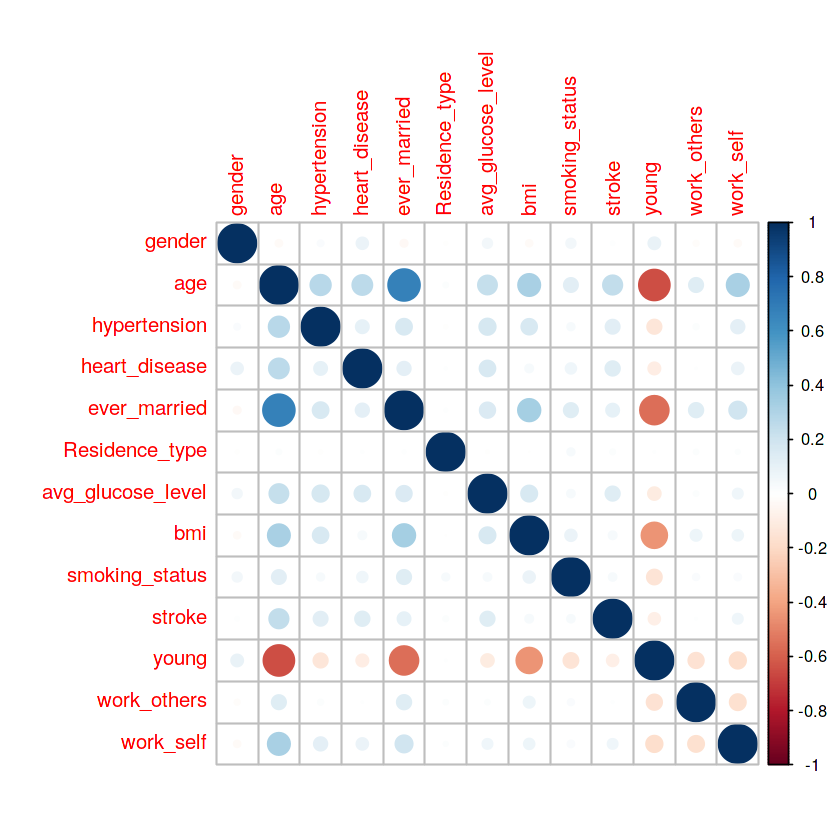

In [11]:
cat("check the correlations")
correlations <- cor(data, method = "pearson", use = "complete.obs")
corrplot(correlations, method="circle")

"Young" are clearly correlated with othesr...  "ever married" also a some... let's not consider them.

In [12]:
data1 <- data[,c("gender","age","hypertension","heart_disease","Residence_type","avg_glucose_level","bmi","smoking_status","work_others","work_self","stroke")]
#after first run analysis, the focus was decided on this variables
data2 <- data[,c("age","hypertension","avg_glucose_level","work_self","stroke")]

#normalize data (excep stroke)
#data3 <- scale(data1[,c(-11)])
data_scaled0 <- scale(data2[,c(-5)])
data_scaled <- cbind(data_scaled0, data$stroke)

data_scaled <- as.data.frame(data_scaled)
data_scaled <- rename(data_scaled,"stroke" =  V5)
print(head(data_scaled))

        age hypertension avg_glucose_level  work_self stroke
1 1.0513314   -0.3285697       2.706110617 -0.4368378      1
2 0.7859932   -0.3285697       2.121350940  2.2887313      1
3 1.6262309   -0.3285697      -0.005027809 -0.4368378      1
4 0.2553167   -0.3285697       1.437217451 -0.4368378      1
5 1.5820079    3.0428986       1.501037522  2.2887313      1
6 1.6704540   -0.3285697       1.768021830 -0.4368378      1


# Nice! Data is great, let's implement ML - be carefull, the stroke is binary!

# Let's try to use a logistic regression first:

**Train Test Split and Scale**

In [13]:
cat("Train Test split - using caret\n")
trainIndex <- createDataPartition(data_scaled$stroke, p = 0.7, 
                                  list = FALSE, 
                                  times = 1)
dataTrain0 <- data_scaled[ trainIndex,]
dataTest  <- data_scaled[-trainIndex,]
head(dataTrain0)
str(dataTrain0)
head(dataTest)
str(dataTest)

Train Test split - using caret


,age,hypertension,avg_glucose_level,work_self,stroke
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0513314,-0.3285697,2.7061106,-0.4368378,1
2,0.7859932,-0.3285697,2.1213509,2.2887313,1
4,0.2553167,-0.3285697,1.4372175,-0.4368378,1
5,1.5820079,3.0428986,1.5010375,2.2887313,1
6,1.6704540,-0.3285697,1.7680218,-0.4368378,1
8,1.1397775,-0.3285697,-0.2596456,-0.4368378,1


'data.frame':	3577 obs. of  5 variables:
 $ age              : num  1.051 0.786 0.255 1.582 1.67 ...
 $ hypertension     : num  -0.329 -0.329 -0.329 3.043 -0.329 ...
 $ avg_glucose_level: num  2.71 2.12 1.44 1.5 1.77 ...
 $ work_self        : num  -0.437 2.289 -0.437 2.289 -0.437 ...
 $ stroke           : num  1 1 1 1 1 1 1 1 1 1 ...


,age,hypertension,avg_glucose_level,work_self,stroke
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1.6262309,-0.3285697,-0.005027809,-0.4368378,1
7,1.3608927,3.0428986,-0.796264185,-0.4368378,1
12,0.7859932,-0.3285697,0.316060019,-0.4368378,1
22,0.3879858,3.0428986,2.807692736,2.2887313,1
27,0.9628853,-0.3285697,-0.114118172,-0.4368378,1
31,0.6091010,3.0428986,2.339310835,-0.4368378,1


'data.frame':	1533 obs. of  5 variables:
 $ age              : num  1.626 1.361 0.786 0.388 0.963 ...
 $ hypertension     : num  -0.329 3.043 -0.329 3.043 -0.329 ...
 $ avg_glucose_level: num  -0.00503 -0.79626 0.31606 2.80769 -0.11412 ...
 $ work_self        : num  -0.437 -0.437 -0.437 2.289 -0.437 ...
 $ stroke           : num  1 1 1 1 1 1 1 1 1 1 ...


**Balance Data**

In [14]:
cat("Balance (train) data by oversampling. From 5% do 30%\n")
dataTrain <- ovun.sample(as.factor(stroke)~.,data = dataTrain0, method = 'over',p = 0.3)$data
str(dataTrain)

Balance (train) data by oversampling. From 5% do 30%
'data.frame':	4865 obs. of  5 variables:
 $ age              : num  0.653 -1.558 -1.292 0.167 1.405 ...
 $ hypertension     : num  3.043 -0.329 -0.329 -0.329 -0.329 ...
 $ avg_glucose_level: num  -0.402 0.105 1.217 2.314 3.034 ...
 $ work_self        : num  -0.437 -0.437 -0.437 -0.437 2.289 ...
 $ stroke           : num  0 0 0 0 0 0 0 0 0 0 ...


**Run Model**

In [15]:
logit_2 <- glm(stroke~., family = binomial,data = dataTrain)

In [16]:
summary(logit_2)
summary(logit_2$fitted.values)


Call:
glm(formula = stroke ~ ., family = binomial, data = dataTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0157  -0.7053  -0.2954   0.7655   3.1797  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.89400    0.06050 -31.308  < 2e-16 ***
age                1.61301    0.05948  27.120  < 2e-16 ***
hypertension       0.13666    0.02863   4.773 1.81e-06 ***
avg_glucose_level  0.20896    0.03017   6.927 4.30e-12 ***
work_self         -0.10161    0.03378  -3.008  0.00263 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5949.6  on 4864  degrees of freedom
Residual deviance: 4301.2  on 4860  degrees of freedom
AIC: 4311.2

Number of Fisher Scoring iterations: 5


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005556 0.059791 0.232703 0.300719 0.532186 0.873094 

In [17]:
cat("Predict on Train")
pred_train0 <- predict(logit_2, type = "response")
pred_train <- ifelse(pred_train0 >0.25,1,0)
sum(pred_train)
#how they look
length(pred_train)
head(pred_train,50)

cat("Predict on Test")
pred_test0 <- predict(logit_2, newdata = dataTest, type = "response")
pred_test <- ifelse(pred_test0 >0.25,1,0)
sum(pred_test)
#how they look
length(pred_test)
head(pred_test,50)

Predict on Train

[1] 2336

[1] 4865

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 1  0  0  0  1  0  1  1  1  0  0  0  0  1  1  1  1  0  1  0  1  0  1  0  0  0 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 0  0  0  1  1  1  1  0  0  1  0  1  0  0  1  0  1  1  0  1  0  0  0  0

Predict on Test

[1] 552

[1] 1533

3   7  12  22  27  31  33  39  42  47  51  52  60  62  69  72  74  78  81  83 
  1   1   1   1   1   1   1   1   0   1   1   1   1   1   1   1   1   1   1   1 
 88  91  96 102 104 105 106 108 113 116 117 120 121 127 133 134 137 138 140 144 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   1   1 
147 150 151 154 157 160 165 166 168 169 
  1   1   1   1   0   1   1   1   1   1

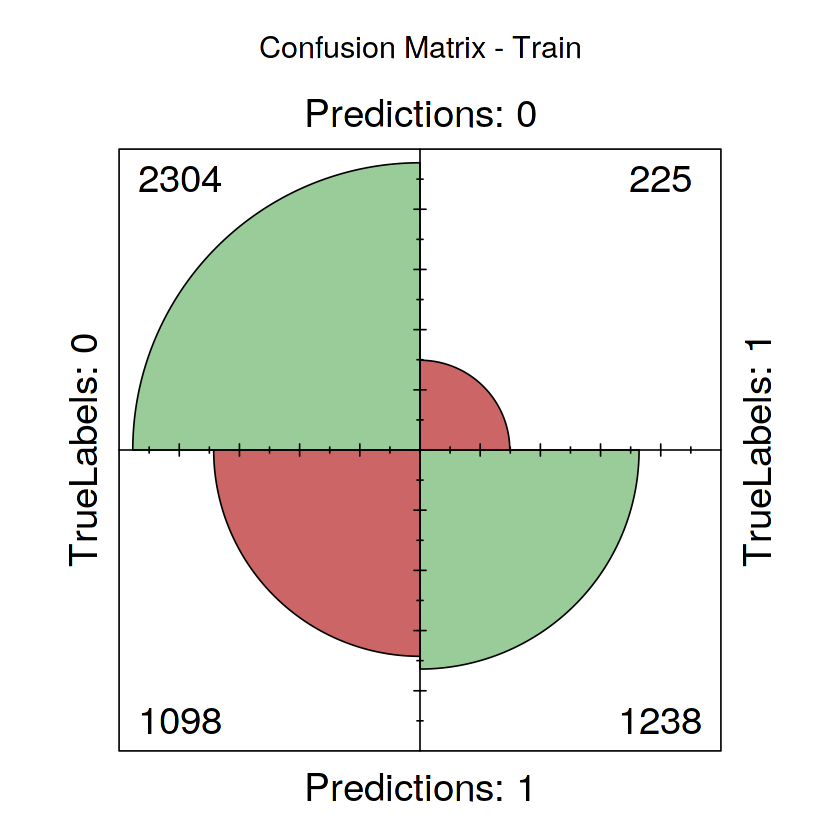

In [18]:
#Confusion Matrix
a1 <- table(Predictions = pred_train, TrueLabels = dataTrain$stroke)
fourfoldplot(a1, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix - Train")

In [19]:
#Accuracy
acc1 <- ( a1[2,2] + a1[1,1] ) / (length(dataTrain$stroke))
cat("Accuracy = ",acc1 )
#F1
Precision1 =  a1[2,2] / ( a1[2,2] + a1[2,1] )
cat("\nPrecision = ",Precision1 )
Recall1 =  a1[2,2] / ( a1[2,2] + a1[1,2] )
cat("\nRecall = ",Recall1 )
F1score1  = 2*(Recall1 * Precision1) / (Recall1 + Precision1)
cat("\nF1 score = ",F1score1 )

Accuracy =  0.7280576
Precision =  0.5299658
Recall =  0.8462064
F1 score =  0.6517505

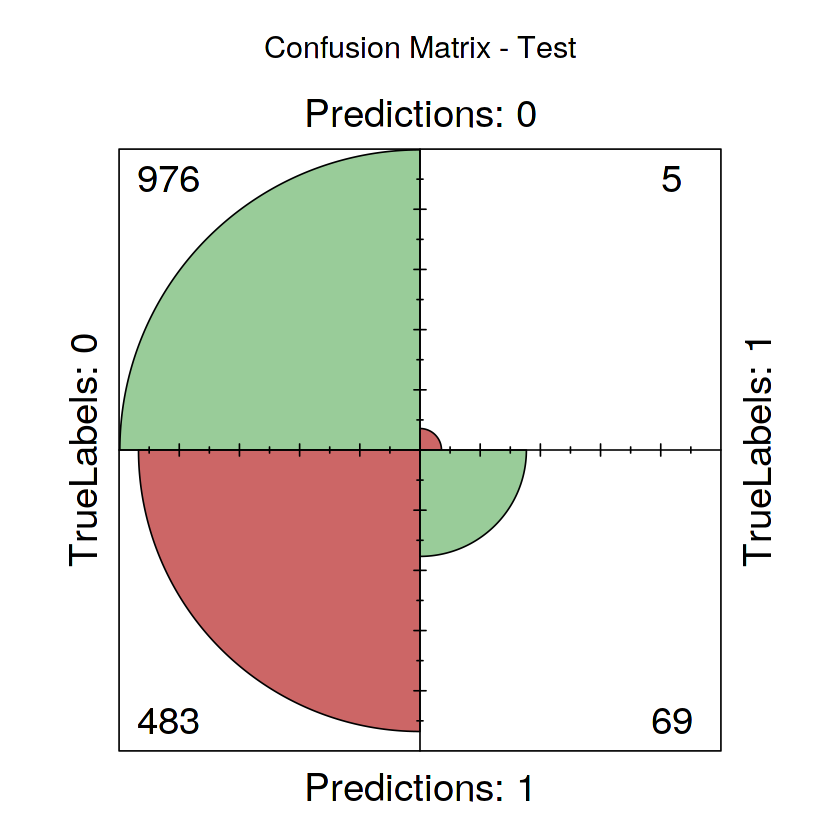

In [20]:
#Confusion Matrix
b1 <- table(Predictions = pred_test, TrueLabels = dataTest$stroke)
fourfoldplot(b1, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix - Test")

In [21]:
#Accuracy
acc1 <- ( b1[2,2] + b1[1,1] ) / (length(dataTest$stroke))
cat("Accuracy = ",acc1 )
#F1
Precision1 =  b1[2,2] / ( b1[2,2] + b1[2,1] )
cat("\nPrecision = ",Precision1 )
Recall1 =  b1[2,2] / ( b1[2,2] + b1[1,2] )
cat("\nRecall = ",Recall1 )
F1score1  = 2*(Recall1 * Precision1) / (Recall1 + Precision1)
cat("\nF1 score = ",F1score1 )

Accuracy =  0.6816699
Precision =  0.125
Recall =  0.9324324
F1 score =  0.2204473

F1 score reasonable for the Train set, but very bad for Test set... Data might have become overfitted because of oversampling.

# Let's try to improve using Random Forest:

Transform data back to categorical - Random Forest can and should dealt with it

In [22]:
cat("Train Test split - using caret\n")
data2$hypertension <- as.factor(data2$hypertension)
data2$work_self <- as.factor(data2$work_self)
data2$stroke <- as.factor(data2$stroke)

Train Test split - using caret


**Train Test Split**

In [23]:
cat("Train Test split - using caret\n")
trainIndex2 <- createDataPartition(data2$stroke, p = 0.7, 
                                  list = FALSE, 
                                  times = 1)
dataTrain02 <- data2[ trainIndex2,]
dataTest2  <- data2[-trainIndex2,]
head(dataTrain02)
str(dataTrain02)
head(dataTest2)
str(dataTest2)

Train Test split - using caret


,age,hypertension,avg_glucose_level,work_self,stroke
,<dbl>,<fct>,<dbl>,<fct>,<fct>
1,67,0,228.69,0,1
3,80,0,105.92,0,1
5,79,1,174.12,1,1
7,74,1,70.09,0,1
8,69,0,94.39,0,1
10,78,0,58.57,0,1


'data.frame':	3578 obs. of  5 variables:
 $ age              : num  67 80 79 74 69 78 61 54 79 64 ...
 $ hypertension     : Factor w/ 2 levels "0","1": 1 1 2 2 1 1 1 1 1 1 ...
 $ avg_glucose_level: num  228.7 105.9 174.1 70.1 94.4 ...
 $ work_self        : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 1 1 1 1 ...
 $ stroke           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


,age,hypertension,avg_glucose_level,work_self,stroke
,<dbl>,<fct>,<dbl>,<fct>,<fct>
2,61,0,202.21,1,1
4,49,0,171.23,0,1
6,81,0,186.21,0,1
9,59,0,76.15,0,1
11,81,1,80.43,0,1
14,78,0,219.84,0,1


'data.frame':	1532 obs. of  5 variables:
 $ age              : num  61 49 81 59 81 78 50 52 79 42 ...
 $ hypertension     : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 2 2 1 1 ...
 $ avg_glucose_level: num  202.2 171.2 186.2 76.2 80.4 ...
 $ work_self        : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 2 2 2 1 ...
 $ stroke           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


**Balance Data**

In [24]:
cat("Balance (train) data by oversampling. From 5% do 30%\n")
dataTrain2 <- ovun.sample(as.factor(stroke)~.,data = dataTrain02, method = 'over',p = 0.3)$data
str(dataTrain2)

Balance (train) data by oversampling. From 5% do 30%
'data.frame':	4826 obs. of  5 variables:
 $ age              : num  3 58 8 52 75 32 79 37 40 35 ...
 $ hypertension     : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 1 1 ...
 $ avg_glucose_level: num  95.1 88 110.9 77.6 243.5 ...
 $ work_self        : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 1 1 1 1 ...
 $ stroke           : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


**Run Model**

In [25]:
rf <- randomForest(stroke ~., data = dataTrain2, ntree = 1000, mtry = 1)

In [26]:
rf
summary(rf)


Call:
 randomForest(formula = stroke ~ ., data = dataTrain2, ntree = 1000,      mtry = 1) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 19.91%
Confusion matrix:
     0   1 class.error
0 3147 256  0.07522774
1  705 718  0.49543219

                Length Class  Mode     
call               5   -none- call     
type               1   -none- character
predicted       4826   factor numeric  
err.rate        3000   -none- numeric  
confusion          6   -none- numeric  
votes           9652   matrix numeric  
oob.times       4826   -none- numeric  
classes            2   -none- character
importance         4   -none- numeric  
importanceSD       0   -none- NULL     
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y               4826   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     
terms              3   terms  call     

In [27]:
cat("Predict on Train")
predRF_train <- predict(rf)
#predRF_train <- ifelse(predRF_train0 >0.10,1,0)
#sum(predRF_train)
#how they look
length(predRF_train)
head(predRF_train,50)

cat("Predict on Test")
predRF_test <- predict(rf, newdata = dataTest2)
#predRF_test <- ifelse(predRF_test0 >0.10,1,0)
#sum(predRF_test)
#how they look
length(predRF_test)
head(predRF_test,50)

Predict on Train

[1] 4826

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0 
Levels: 0 1

Predict on Test

[1] 1532

2   4   6   9  11  14  16  22  23  32  35  36  38  41  43  44  47  55  57  68 
  0   0   1   0   1   1   0   0   0   0   0   0   1   0   0   0   0   1   0   0 
 70  74  75  76  77  81  82  83  86  87  88  92  94 100 105 106 108 111 112 116 
  1   1   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   1   0   1 
129 132 133 134 139 143 145 151 152 161 
  1   1   1   0   1   1   1   1   1   0 
Levels: 0 1

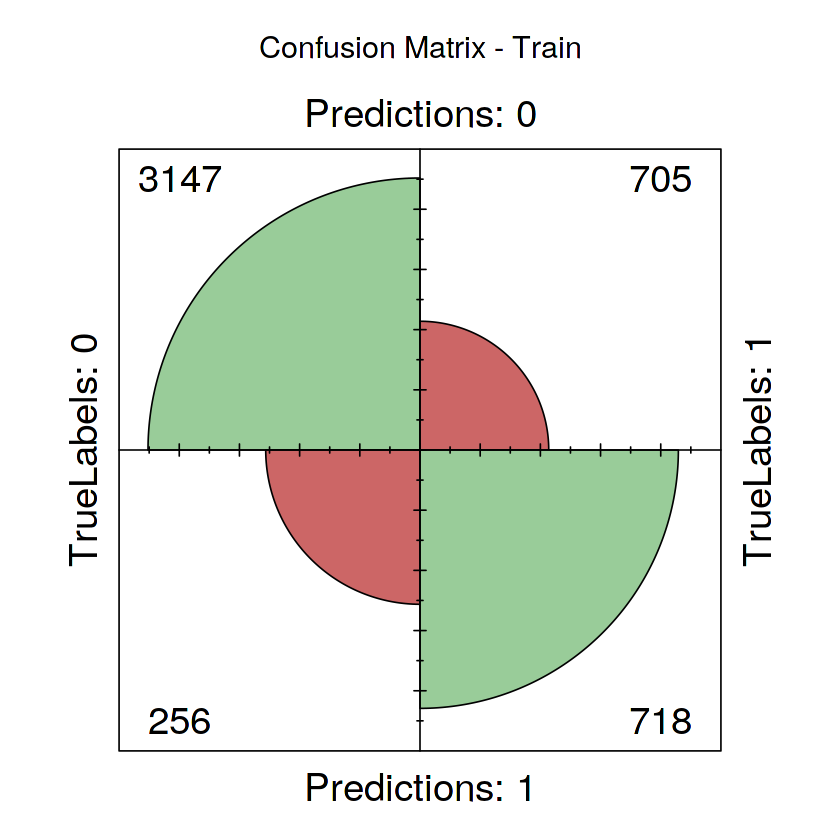

In [28]:
#Confusion Matrix
a2 <- table(Predictions = predRF_train, TrueLabels = dataTrain2$stroke)
fourfoldplot(a2, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix - Train")

In [29]:
#Accuracy
acc2 <- ( a2[2,2] + a2[1,1] ) / (length(dataTrain2$stroke))
cat("Accuracy = ",acc2 )
#F1
Precision2 =  a2[2,2] / ( a2[2,2] + a2[2,1] )
cat("\nPrecision = ",Precision2 )
Recall2 =  a2[2,2] / ( a2[2,2] + a2[1,2] )
cat("\nRecall = ",Recall2 )
F1score2  = 2*(Recall2 * Precision2) / (Recall2 + Precision2)
cat("\nF1 score = ",F1score2 )

Accuracy =  0.8008703
Precision =  0.7371663
Recall =  0.5045678
F1 score =  0.5990822

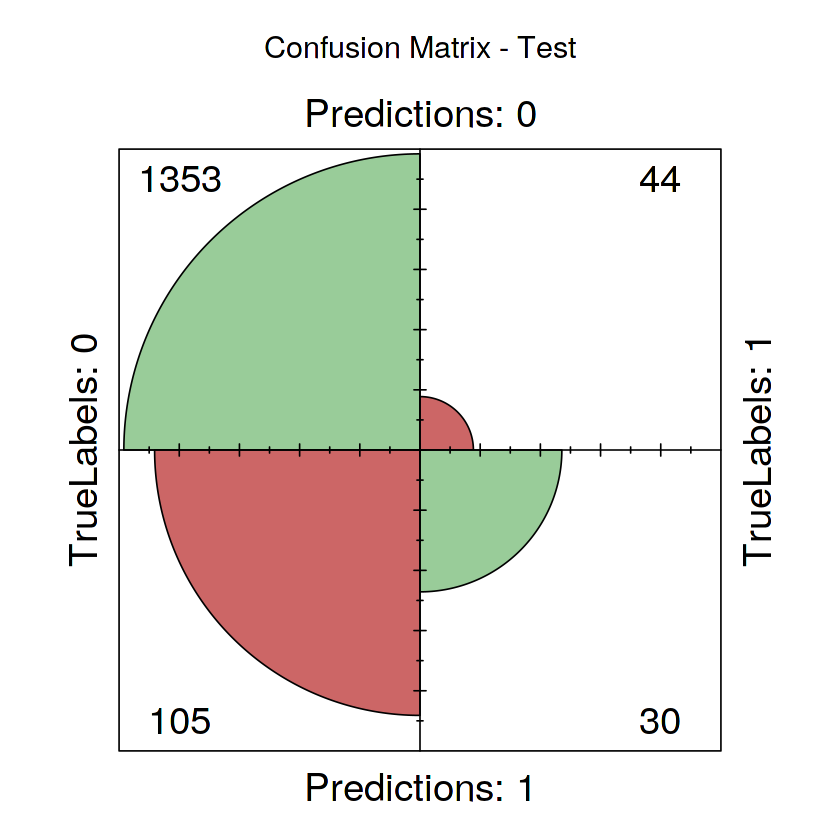

In [30]:
#Confusion Matrix
b2 <- table(Predictions = predRF_test, TrueLabels = dataTest2$stroke)
fourfoldplot(b2, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix - Test")

In [31]:
#Accuracy
acc2 <- ( b2[2,2] + b2[1,1] ) / (length(dataTest2$stroke))
cat("Accuracy = ",acc2 )
#F1
Precision2 =  b2[2,2] / ( b2[2,2] + b2[2,1] )
cat("\nPrecision = ",Precision2 )
Recall2 =  b2[2,2] / ( b2[2,2] + b2[1,2] )
cat("\nRecall = ",Recall2 )
F1score2  = 2*(Recall2 * Precision2) / (Recall2 + Precision2)
cat("\nF1 score = ",F1score2 )

Accuracy =  0.9027415
Precision =  0.2222222
Recall =  0.4054054
F1 score =  0.2870813

Result is better for Random Forest model. The Accuracy is much better. <br>
F1 score is good for the Train set, but not so good for Test set... again, data might have become overfitted.
